##Description:

    Use DeSeq2 to identify differential abundance among treatments
    Following  Ashley's succ-C notebook


# Setting variables

In [3]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [4]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [5]:
%matplotlib inline
%load_ext rpy2.ipython

In [6]:
%%R
# The required package list:
reqpkg = c("BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.8’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.2’
[1] "ggplot2"
[1] ‘1.0.1’
[1] "gridExtra"
[1] ‘0.9.1’
[1] "scales"
[1] ‘0.2.5’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.2’
[1] "tidyr"
[1] ‘0.2.0’
[1] "reshape2"
[1] ‘1.4.1’
[1] "vegan"
[1] ‘2.3.0’


In [7]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [8]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 8.0K
lrwxrwxrwx 1 bryan bryan 130 Jul 26 09:26 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan 143 Jul 26 09:26 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom


###Load some theme parameters for ggplot2

In [9]:
%%R
theme_set(theme_bw())
pal = "Set1"
scale_colour_discrete <- function(palname = pal, ...) {
    scale_colour_brewer(palette = palname, ...)
}
scale_fill_discrete <- function(palname = pal, ...) {
    scale_fill_brewer(palette = palname, ...)
}

# Loading/editting OTU table

In [119]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



##apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [120]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

Remove controls and relevel factors so that bare is the reference level

In [121]:
%%R
#remove controls
physeq = subset_samples(physeq, !is.na(Plant))
#re-order levels 
sample_data(physeq)$Plant = relevel(sample_data(physeq)$Plant, "BARE")

##Filter samples
Initial run without filtering, consider filtering to test effects
 

##Create DeSeq2 object

In [122]:
%%R
library("BiocParallel")
register(MulticoreParam(6))

###Initial run is all plants, which will group bare soils into a single group

In [96]:
%%R
#s = sample_data(physeq)
#s$Planted = factor(ifelse(s$Plant == "BARE", "BARE", "Rhizosphere"))
#sample_data(physeq) = s
#sample_data(physeq) %>% str()

'data.frame':	240 obs. of  22 variables:
Formal class 'sample_data' [package "phyloseq"] with 4 slots
  ..@ .Data    :List of 22
  .. ..$ : Factor w/ 240 levels "sample1-1.06_Nneg",..: 18 166 79 67 17 153 105 154 56 87 ...
  .. ..$ : int  1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ : int  1 2 1 1 1 2 2 2 1 1 ...
  .. ..$ : Factor w/ 93 levels "A1","A10","A11",..: 93 63 16 51 82 27 48 39 27 7 ...
  .. ..$ : int  72 86 90 85 71 83 68 84 83 25 ...
  .. ..$ : int  72 182 90 85 71 179 164 180 83 25 ...
  .. ..$ : int  72 182 90 85 71 179 164 180 83 25 ...
  .. ..$ : Factor w/ 184 levels "1.03_Nneg","1.03_Npos",..: 6 180 179 5 5 103 103 104 104 33 ...
  .. ..$ : Factor w/ 23 levels "BARE","75-062",..: 1 1 1 1 1 1 1 1 1 2 ...
  .. ..$ : num  1.06 4.27 4.27 1.06 1.06 3.07 3.07 3.07 3.07 1.22 ...
  .. ..$ : Factor w/ 2 levels "Nneg","Npos": 2 2 1 1 1 1 1 2 2 1 ...
  .. ..$ : int  1 4 4 1 1 3 3 3 3 1 ...
  .. ..$ : int  53 79 61 61 53 79 72 79 57 72 ...
  .. ..$ : Factor w/ 8 levels "sample1","sample2",..:

In [97]:
%%R
#p.dds = phyloseq_to_deseq2(physeq, ~Planted)
#p.dds = DESeq(p.dds, test = "Wald", fitType="parametric", parallel = TRUE)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 6 workers
mean-dispersion relationship
final dispersion estimates, MLE betas: 6 workers
fitting model and testing: 6 workers
-- replacing outliers and refitting for 250 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


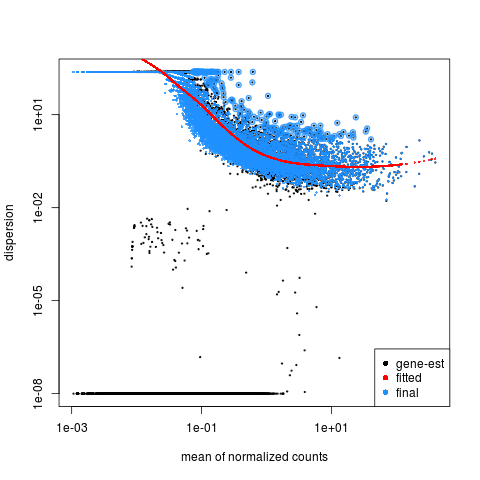

In [22]:
%%R
plotDispEsts(p.dds)

In [123]:
%%R
sample_data(physeq)$DAP = factor(sample_data(physeq)$DAP) 
sample_data(physeq)$DAP %>% levels

[1] "36" "53" "57" "61" "72" "79" "84" "88"


In [24]:
%%R
res=results(p.dds, contrast=
                    c("Plant","HELAN", "BARE"), parallel = TRUE)
res

log2 fold change (MAP): Plant HELAN vs BARE 
Wald test p-value: Plant HELAN vs BARE 
DataFrame with 11246 rows and 6 columns
             baseMean log2FoldChange     lfcSE        stat       pvalue
            <numeric>      <numeric> <numeric>   <numeric>    <numeric>
OTU.5899  0.313291964     -0.8474776 0.9347480  -0.9066375  0.364598523
OTU.11339 0.004029448      0.0909197 0.8504632   0.1069061  0.914863473
OTU.11867 0.005192205      0.2700464 0.8502802   0.3175970  0.750790678
OTU.12445 0.003062072      0.1237808 0.8503781   0.1455597  0.884269002
OTU.8680  2.987339280     -1.8466944 0.6308831  -2.9271577  0.003420754
...               ...            ...       ...         ...          ...
OTU.9197   0.01238060    -0.06728385 0.8509921 -0.07906519 9.369808e-01
OTU.3516   0.68764603    -3.41212770 0.9300910 -3.66859542 2.438867e-04
OTU.7196   0.04294295    -0.31456994 0.8757143 -0.35921525 7.194341e-01
OTU.4116   0.27142295    -1.79684357 0.9612969 -1.86918685 6.159682e-02
OTU.7969   

In [26]:
%%R
#summary(res) %>% print
plotMA(res, main="DESeq2", ylim=c(-2,2))


out of 11218 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 763, 6.8% 
LFC < 0 (down)   : 2052, 18% 
outliers [1]     : 0, 0% 
low counts [2]   : 5066, 45% 
(mean count < 0.1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
Error in as.vector(data) : 
  no method for coercing this S4 class to a vector


In [124]:
%%R


#asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Plant)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    theta = 0.5
    r = results(diagdds)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    return(r[, c("log2FoldChange", "p")])
}

deseq_prune = function(physeq.obj, day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples(physeq.md$DAP == day)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > (0.01 * length(x)), TRUE)
    return(p.thresh)
}

In [125]:
%%R -w 1200 -h 600

days = c('36', '53', '57', '61', '72', '79', '84', '88')
res.list = vector("list", length(days))
names(res.list) = as.character(days)
                           
for (day in days) {
    DF = NULL
    physeq.day = deseq_prune(physeq, day)
    DF = get_Ps(physeq.day)
    supp = tax_table(physeq.day)
    if( !setequal(row.names(DF), row.names(supp)) ){
			stop("Ordination and supplementary data indices differ on the following:\n.",
			setdiff(row.names(DF), row.names(supp)))
	}
	DF <- data.frame(DF, supp)
    DF$OTU = rownames(DF)
    res.list[[as.character(day)]] = DF
}

pVal_day = ldply(res.list, function(x) x)
names(pVal_day)[1] = "Day"
pVal_day$Day = factor(as.numeric(pVal_day$Day))

pVal_day = subset(pVal_day, !is.na(pVal_day$log2FoldChange))

# Phylum order
x = tapply(pVal_day$log2FoldChange, pVal_day$Rank2, function(x) max(x))
x = sort(x, decreasing = TRUE, na.last = TRUE)
pVal_day$Rank2 = factor(as.character(pVal_day$Rank2), levels = names(x))

p = ggplot(pVal_day, aes(x = Rank2, y = log2FoldChange)) 
p = p + geom_hline(y = 1) + geom_point(aes(fill = Rank2), pch = 21, alpha = 0.45, color = "#151515") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 12),
          strip.text.x = element_text(size = 16)) + guides(fill = FALSE) +
    facet_wrap(~Day) + labs(x = "Phylum")
print(p)

Error in nsamples(x) : 
  error in evaluating the argument 'physeq' in selecting a method for function 'nsamples': Error: argument "x" is missing, with no default
